# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
import warnings
warnings.simplefilter(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [33]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.models import load_model
from keras import backend as K

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os, glob, csv, imageio
from tqdm import tqdm
from copy import copy
from collections import Counter

First of all, you have you have to read the data. Run the cell below to unpack data.

In [4]:
# from get_data import unpack
# unpack('Face_Recognition_data.zip')

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [5]:
def load_images(dirname, verbose=True):
    imgs_dict = {}

    if verbose:
        print(f'Loading images from {dirname}')

    for im_path in tqdm(glob.glob(dirname+"/*.jpg"), disable=not verbose):
        filename = os.path.basename(im_path)
        img = imageio.imread(im_path)        
        imgs_dict[filename] = img
    return imgs_dict

def read_labels(dirname, filename, verbose=True):
    labels = {}
    filedir = fr'{dirname}/{filename}.csv'
    if verbose:
        print(f'Loading file {filedir}')
    with open(filedir, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            labels[str(row[0])] = str(row[1])
    return labels

def load_image_data(dirname='Face_Recognition_data/image_classification/'):
    train_imgs = load_images(os.path.join(dirname, 'train/images'))
    test_imgs = load_images(os.path.join(dirname, 'test/images'))

    train_labels = read_labels(os.path.join(dirname, 'train'), 'y_train')
    test_labels = read_labels(os.path.join(dirname, 'test'), 'y_test')
    
    return train_imgs, train_labels, test_imgs, test_labels

In [6]:
x_train, y_train, x_test, y_test = load_image_data()
print('%d'%len(x_train), '\ttraining images')
print('%d'%len(x_test), '\ttesting images')

Loading images from Face_Recognition_data/image_classification/train/images
100%|██████████| 661/661 [00:06<00:00, 95.00it/s]
Loading images from Face_Recognition_data/image_classification/test/images
100%|██████████| 808/808 [00:08<00:00, 98.43it/s]
Loading file Face_Recognition_data/image_classification/train/y_train.csv
Loading file Face_Recognition_data/image_classification/test/y_test.csv
661	training images
808	testing images


In [7]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    plt.figure(figsize = (3*n_cols,3*n_rows))
    for n, i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

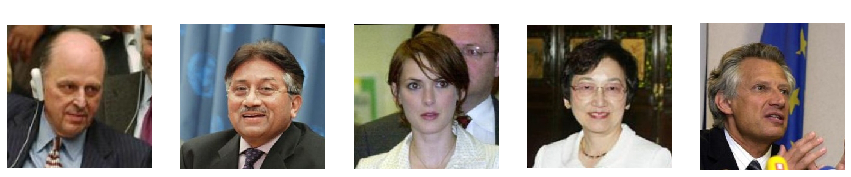

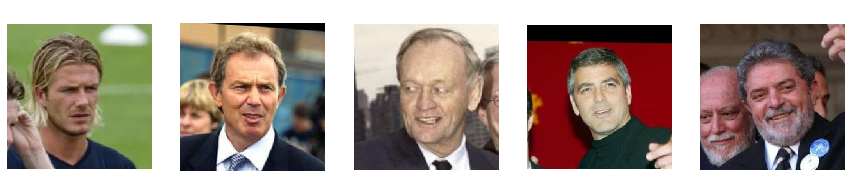

In [8]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [9]:
def load_video(dirname, verbose=True):
    videos_dict = {}
    subdirs = [d_name for d_name in os.listdir(dirname) if os.path.isdir(os.path.join(dirname, d_name))]
    
    if verbose:
        print(f'Loading videos from {dirname}')

    for subdir in tqdm(subdirs, disable=not verbose):
        imgs_dict = load_images(os.path.join(dirname, subdir), verbose=False)
        frames_name = list(sorted(imgs_dict))
        imgs_list = [imgs_dict[k] for k in frames_name]
        videos_dict[os.path.basename(subdir)] = imgs_list
    return videos_dict
    
def load_video_data(dirname = r'Face_Recognition_data/video_classification'):
    train_videos = load_images(os.path.join(dirname, 'train/images/'))
    test_videos = load_video(os.path.join(dirname, 'test/videos/'))

    train_labels = read_labels(os.path.join(dirname, 'train'), 'y_train')
    test_labels = read_labels(os.path.join(dirname, 'test'), 'y_test')
    return train_videos, train_labels, test_videos, test_labels

In [10]:
# I will do it later to reduce memory consumption
# video_train, train_labels, video_test, test_labels = load_video_data()
# print('%d'%len(video_train), '\ttraining images')
# print('%d'%len(video_test), '\ttesting videos')

In [11]:
# visualize(video_train, train_labels)

In [12]:
# visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [34]:
MODEL_KEYPOINTS = load_model('model_facial_keypoints.h5')

In [14]:
import cvlib as cv
from skimage.transform import rotate

def get_face(img):
    faces, confidences = cv.detect_face(img)
    
    if len(confidences) == 0:
        # if faces not found return all img
        face = [0, 0, img.shape[1], img.shape[0]]
    else:
        # process case if several face would be detected
        max_index = confidences.index(max(confidences))
        face = faces[max_index]
    return face

def expand_face_boundary(img, boundary):
    # add some space around face to make it more similar to training set fo keypoint model
    start_x, start_y, end_x, end_y = tuple(boundary)
    height, width = end_y - start_y, end_x - start_x

    new_size = int(max([height, width])*1.1)
    add_height, add_width = int((new_size - height)/2), int((new_size - width)/2)
    start_x, end_x = max(0, start_x-add_width), min(img.shape[1], end_x+add_width)
    start_y, end_y = max(0, start_y-add_height), min(img.shape[1], end_y+add_height)
    return start_x, start_y, end_x, end_y

def get_rotation_parameters(face_img):
    # get dimensionless keupoints
    # model input shape = (None, 100, 100, 3)  
    keypoints = MODEL_KEYPOINTS.predict(face_img)

    height, width = face_img.shape[2], face_img.shape[1]
    keypoints = keypoints.reshape(14, 2)
    keypoints = (keypoints + 0.5)*np.array([width, height])
    
    left_eye_center = keypoints[4:6, :].mean(axis=0)
    right_eye_center = keypoints[7:9, :].mean(axis=0)

    eyes_vec = right_eye_center - left_eye_center
    eyes_center = (left_eye_center + right_eye_center)/2
    angle = np.arctan2(eyes_vec[1], eyes_vec[0])/np.pi*180
    return eyes_center, angle

def rotate_img(img, face_boundary, relative_center, angle):
    start_x, start_y, end_x, end_y = tuple(face_boundary)
    height, width = end_y - start_y, end_x - start_x
    absolute_center_face = relative_center/100*np.array([width, height])
    absolute_center_img = absolute_center_face.astype('int') + np.array([start_x, start_y])

    rotated_img = rotate(img, angle, center=absolute_center_img, preserve_range=True)
    return rotated_img

def crop_and_resize(img, boundary, new_shape=(100, 100)):
    start_x, start_y, end_x, end_y = boundary
    cropped_img = img[start_y:end_y, start_x:end_x, :]
    resized_img = cv2.resize(cropped_img, new_shape).reshape(1, new_shape[0], new_shape[1], 3)
    return resized_img

def normalize(img):
    return img/255

def process_img(img):
    face_boundary = get_face(img)
    face_boundary = expand_face_boundary(img, boundary=face_boundary)

    img_face = crop_and_resize(img, face_boundary, new_shape=(100, 100))
    img_face = normalize(img_face)    
    relative_center, angle = get_rotation_parameters(img_face)

    img = rotate_img(img, face_boundary, relative_center, angle)
    img = crop_and_resize(img, face_boundary, new_shape=(224, 224))

    img = normalize(img)
    return img #np.expand_dims(img, axis=0)


In [15]:
def preprocess_imgs(imgs, is_series=False):
    if is_series:
        assert isinstance(imgs, list), 'imgs for flag is_series should be packed in list'
        processed_imgs = []
        for img in imgs:
            img = process_img(img)
            processed_imgs.append(img)
        imgs = np.concatenate(processed_imgs, axis=0)
    else:
        imgs = process_img(imgs[0])
    return imgs

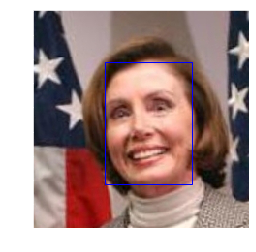

In [16]:
import cvlib as cv
import matplotlib.patches as patches

image = x_train['5.jpg']
faces, confidences = cv.detect_face(image)
fig,ax = plt.subplots(1)
ax.imshow(image)

# loop through detected faces and add bounding box
for face in faces:
    start_x, start_y = face[0], face[1]
    end_x, end_y = face[2], face[3]
    height, width = end_y - start_y, end_x - start_x    
    rect = patches.Rectangle((start_x, start_y), width, height, 0, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
plt.show()
plt.close()

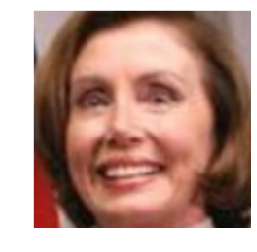

In [17]:
plt.imshow(preprocess_imgs([image])[0])

#### Visualization of preprocessing

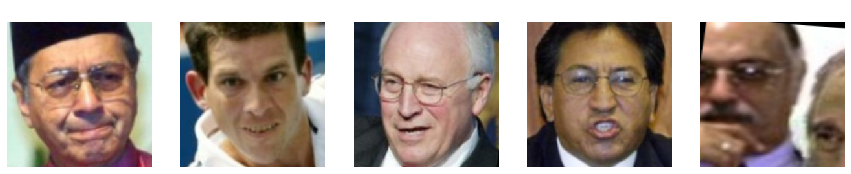

In [18]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [35]:
import h5py
from keras.models import load_model
MODEL = load_model('face_recognition_model.h5')
MODEL.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168
_______________________________________________________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [20]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = MODEL.get_layer(layer).output
    feature_extraction_model = Model(MODEL.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [21]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from skimage.io import imread
import cv2
from os.path import join
from collections import Counter
import random


from sklearn.preprocessing import LabelEncoder

class Classifier():
    def __init__(self):
        self.clf = LinearSVC()
        self.le = LabelEncoder()


    def fit(self, train_imgs, train_labels):
        img_keys = set(list(train_imgs.keys()))
        label_keys = set(list(train_labels.keys()))
        common_keys = list(img_keys.intersection(label_keys))

        labels = [train_labels[key] for key in common_keys]
        labels_encoded = self.le.fit_transform(labels)

        image_embeddings = [train_imgs[key] for key in common_keys]
        image_embeddings = preprocess_imgs(image_embeddings, is_series=True)
        image_embeddings = get_layer_output(image_embeddings, layer = 'fc6')

        self.clf.fit(image_embeddings, labels_encoded)
        del image_embeddings, labels_encoded


    def classify_images(self, test_imgs):
        imgs_keys = test_imgs.keys()
        image_embeddings = [test_imgs[key] for key in imgs_keys]
        image_embeddings = preprocess_imgs(image_embeddings, is_series=True)
        image_embeddings = get_layer_output(image_embeddings, layer = 'fc6')

        output = self.clf.predict(image_embeddings)
        output = self.le.inverse_transform(output)
        dict_output = {k:v for k, v in zip(imgs_keys, output)}
        return dict_output    
        
    def classify_videos(self, test_video):
        imgs_keys = test_video.keys()
        dict_output = {}
        for key in imgs_keys:
            random_items = random.sample(range(len(test_video[key])), 25)
            image_embeddings = [test_video[key][i] for i in random_items]
            image_embeddings = preprocess_imgs(image_embeddings, is_series=True)
            image_embeddings = get_layer_output(image_embeddings, layer = 'fc6')

            output = self.clf.predict(image_embeddings)
            output = self.le.inverse_transform(output)
            freq = Counter(output)
            most_common = freq.most_common(1)[0][0]
            dict_output[key] = most_common
        return dict_output

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [23]:
img_classifier = Classifier()
img_classifier.fit(x_train, y_train)
y_out = img_classifier.classify_images(x_test)

### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [24]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [25]:
print(check_test(y_out, y_test))

Classification accuracy is 0.9616


In [26]:
del x_train, y_train, x_test, y_test

### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [27]:
video_train, train_labels, video_test, test_labels = load_video_data()
print('%d'%len(video_train), '\ttraining images')
print('%d'%len(video_test), '\ttesting videos')

Loading images from Face_Recognition_data/video_classification\train/images/
100%|██████████| 729/729 [00:09<00:00, 77.29it/s]
Loading videos from Face_Recognition_data/video_classification\test/videos/
100%|██████████| 70/70 [01:47<00:00,  1.53s/it]
Loading file Face_Recognition_data/video_classification\train/y_train.csv
Loading file Face_Recognition_data/video_classification\test/y_test.csv
729	training images
70	testing videos


In [28]:
video_classifier = Classifier()
video_classifier.fit(video_train, train_labels)
y_video_out = video_classifier.classify_videos(video_test)

In [29]:
print(check_test(y_video_out, test_labels))

Classification accuracy is 0.8714


In [30]:
#del video_train, train_labels, video_test, test_labels